# Enviornment Check

In [ ]:
import sys
from pathlib import Path
import os 
from datetime import datetime
os.chdir(Path.cwd().parent)
sys.version


In [2]:
import numpy as np
from src import DataImport
import matplotlib.pyplot as plt
from src import Models
import shap
import pandas as pd 
import xgboost
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_val_score,train_test_split,KFold
from src import Evaluate

test_size = 0.3
df = DataImport.data_reader_by_us(bio=False)
df = df.loc[df['age']>=50]
domains = DataImport.domain_dict()
var_dict = DataImport.variable_dict()
var_dict['ZincomeT'] = 'Income'
var_dict['ZwealthT'] = 'Wealth'
var_dict['rocc'] = 'Lower Occupational Status'

df.shape

(13575, 72)

In [3]:
random_state = 87785

# Super Learner Developing 

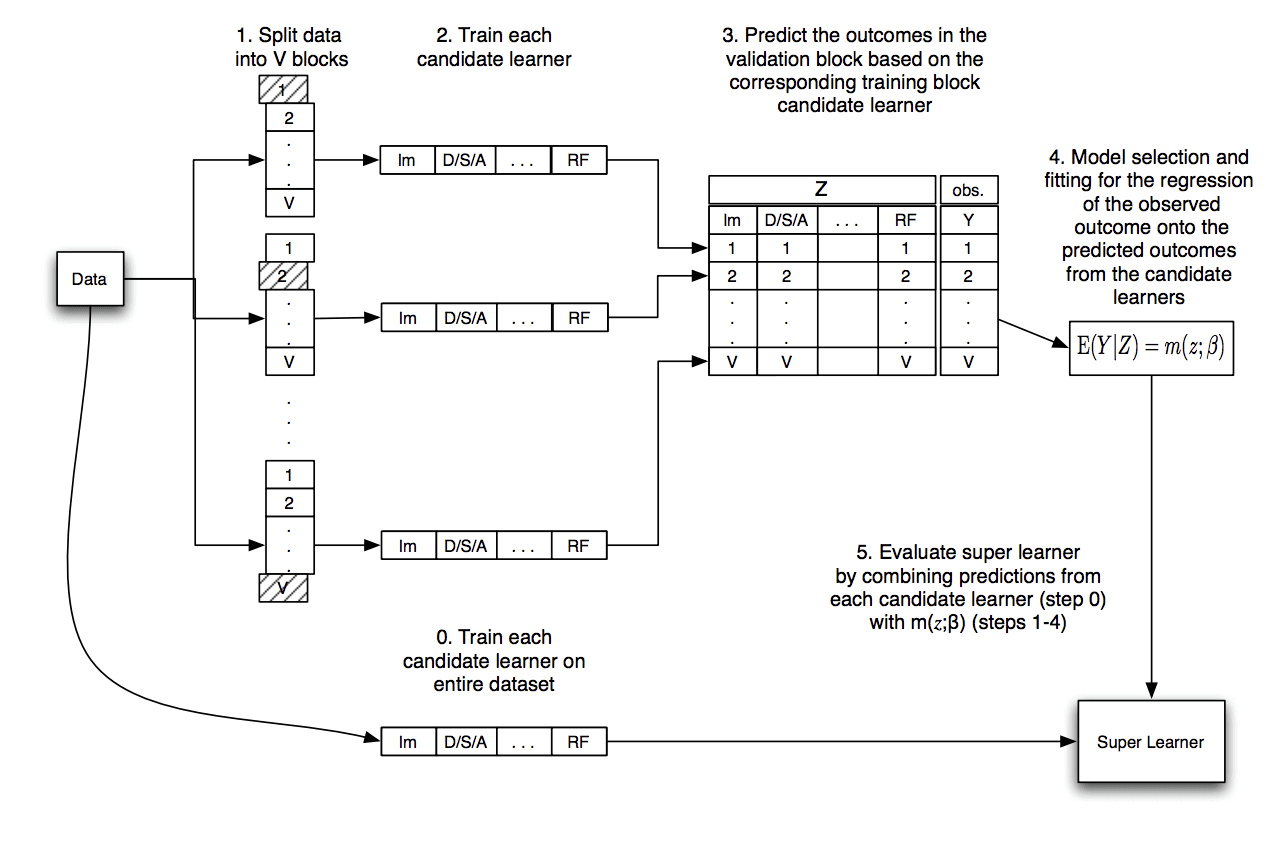

## Step 1 Split Data into V Blocks

X, y = make_regression(n_samples=1000, n_features=100, noise=0.5)

In [4]:
data=df.copy()
test_size=0.3
domain_list=domains['all']

y_colname='death'
k=10

In [44]:
import xgboost as XGB
import lightgbm as LGBM
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

def get_models():
    models = {}
    models['XGB']=XGB.XGBClassifier()
    models['LGB']=LGBM.LGBMClassifier()
    models['SGD']=SGDClassifier(loss='log_loss')
    models['DecisionTree']= DecisionTreeClassifier()
    models['AdaBoost']=AdaBoostClassifier()
    models['LogisticRegression']=LogisticRegression(solver='liblinear')
    models['SVC']=SVC(gamma='scale', probability=True)
    models['Gaussian']=GaussianNB()
    models['KNeighbors']=KNeighborsClassifier()
    models['Bagging']=BaggingClassifier(n_estimators=10)
    models['RandomForest']=RandomForestClassifier(n_estimators=10)
    models['ExtraTrees']=ExtraTreesClassifier(n_estimators=10)
    return models


def meta_model(df_pred):

    X = df_pred[list(get_models().keys())]
    y = df_pred['ori_data']

    #model = LinearRegression()
    model = XGB.XGBClassifier()
    model.fit(X,y)
    return model

def meta_data_generation(X,y,y_colname,k,domain_list,random_state):
    '''
    generate meta data to develop meta model
    '''
    models = get_models()
    kfold=StratifiedKFold(n_splits=k,random_state=random_state,shuffle=True)
    df_pred = pd.DataFrame(columns = ['fold','ori_data']+list(models.keys()))


    # train on each subset
    for i,(train_idx, test_idx) in enumerate(kfold.split(X,y[y_colname])):

        # get the fold data
        print(f'fold {i+1}')
        X_fold_train,y_fold_train = X.loc[train_idx,],y.loc[train_idx,y_colname]
        X_fold_test,y_fold_test = X.loc[test_idx,],y.loc[test_idx,y_colname]

        # train lerner
        temp = pd.DataFrame()

        temp['fold']=[i+1]*len(test_idx)
        temp['y_ind']=test_idx
        temp['ori_data'] = list(y_fold_test)

        #print(len(test_idx), y_fold_test.shape,  temp['ori_data'].unique(), y_fold_test.unique())

        for model in models.keys():
            print(model)
            models[model].fit(X_fold_train[domain_list],y_fold_train)
            pred = [x[1] for x in models[model].predict_proba(X_fold_test[domain_list])]

            temp[model] = pred


        df_pred=pd.concat([df_pred,temp],axis=0)
    return df_pred


def base_model_prediction(base_models,X,y,X_test,y_test):
    """
    X,y:train dataset 
    """
    df_base_pred = pd.DataFrame(columns=['ori_data']+list(base_models.keys()))
    df_base_pred['ori_data']=list(y_test)
    
    for model_name in base_models.keys():
            base_models[model_name].fit(X[domain_list],y[y_colname])  #train in the whole train set 
            df_base_pred[model_name]=[x[1] for x in base_models[model_name].predict_proba(X_test[domain_list])]
    return df_base_pred


            
            

In [45]:



class superlearner():
    
    def __init__(self,data,test_size,domain_list,y_colname,k,random_state):
        super(superlearner,self).__init__()
        self.name = 'sl'
        # first split data 
        self.X_train, self.X_test, self.y_train, self.y_test  = train_test_split(data.drop(y_colname, axis=1), data[y_colname], test_size=test_size, random_state=random_state)        

        # prepare for train-test splitting
        self.X_train.reset_index(inplace=True)
        self.y_train=pd.DataFrame(self.y_train).reset_index()

        # meta data generating
        self.df_meta = meta_data_generation(X=self.X_train,y=self.y_train,y_colname=y_colname,k=k,domain_list=domain_list,random_state=random_state)

        # fit the meta-model (an ensemble model that bring the meta-data together)
        self.meta_model = meta_model(df_pred=self.df_meta)
        
        # 
        self.base_models = get_models()
        
        self.df_base_pred = base_model_prediction(base_models=self.base_models,
                                                  X=self.X_train, 
                                                  X_test=self.X_test, 
                                                  y=self.y_train, 
                                                  y_test=self.y_test)
        self.meta_x = self.df_base_pred.drop(columns=['ori_data'])
        self.df_base_pred['sl']=[x[1] for x in self.meta_model.predict_proba(self.meta_x)]




In [46]:
superlearner=superlearner(data,test_size,domain_list,y_colname,k,random_state)

fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9
fold 10


In [47]:
from sklearn.metrics import f1_score, precision_recall_curve, auc, roc_auc_score

df_base_pred = superlearner.df_base_pred
for model_name in list(get_models().keys())+['sl']:
    y_test = df_base_pred['ori_data']
    y_test_pred_prob = df_base_pred[model_name]


    precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_pred_prob)
    pr_auc= auc(recall_test, precision_test)
    auc_score = roc_auc_score(y_test, y_test_pred_prob)

    print(f'for model {model_name}, pr_auc={pr_auc},auc_score = {auc_score} ')

for model XGB, pr_auc=0.6458229924593557,auc_score = 0.7979042175022075 
for model LGB, pr_auc=0.6885258149880236,auc_score = 0.8243576635536434 
for model SGD, pr_auc=0.671166623738793,auc_score = 0.8110184064957934 
for model DecisionTree, pr_auc=0.5776851290297508,auc_score = 0.6339068524998174 
for model AdaBoost, pr_auc=0.6899313157824912,auc_score = 0.8186739279704105 
for model LogisticRegression, pr_auc=0.7072726719210859,auc_score = 0.8313883213380701 
for model SVC, pr_auc=0.695752880696674,auc_score = 0.8196083648344954 
for model Gaussian, pr_auc=0.5512802798086922,auc_score = 0.7493372066236388 
for model KNeighbors, pr_auc=0.6198002658817584,auc_score = 0.7528943697285406 
for model Bagging, pr_auc=0.6233673799883873,auc_score = 0.7652665592364084 
for model RandomForest, pr_auc=0.5997126659485118,auc_score = 0.7566456435803169 
for model ExtraTrees, pr_auc=0.5981031981674487,auc_score = 0.7463701848123958 
for model sl, pr_auc=0.663812157658181,auc_score = 0.803015521608

# developing notes

In [ ]:
X,X_test,y,y_test = train_test_split(data.drop(y_colname, axis=1), data[y_colname], test_size=test_size, random_state=random_state)        


In [ ]:
import xgboost as XGB
import lightgbm as LGBM
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

def get_models():
    models = {}
    models['xgb']=XGB.XGBClassifier()
    models['lgb']=LGBM.LGBMClassifier()
    return models
    #TODO: More models 

In [ ]:
X.reset_index(inplace=True)
y=pd.DataFrame(y).reset_index()

In [ ]:
y['death'].unique()

## Step 2-4 Metadata generation/meta model fit

In [ ]:
# 2&3 generate the meta_data 
def meta_data_generation(X,y,y_colname,k,domain_list,random_state):
    
    models = get_models()
    kfold=StratifiedKFold(n_splits=k,random_state=random_state,shuffle=True)
    df_pred = pd.DataFrame(columns = ['fold','ori_data']+list(models.keys()))
    
    
    # train on each subset 
    for i,(train_idx, test_idx) in enumerate(kfold.split(X,y[y_colname])):
        
        # get the fold data 
        print(f'fold {i+1}')
        X_fold_train,y_fold_train = X.loc[train_idx,],y.loc[train_idx,y_colname]
        X_fold_test,y_fold_test = X.loc[test_idx,],y.loc[test_idx,y_colname]

        # train lerner
        temp = pd.DataFrame()
        
        temp['fold']=[i+1]*len(test_idx)
        temp['y_ind']=test_idx
        temp['ori_data'] = list(y_fold_test)
        
        #print(len(test_idx), y_fold_test.shape,  temp['ori_data'].unique(), y_fold_test.unique())
        
        for model in models.keys():
            models[model].fit(X_fold_train[domain_list],y_fold_train)
            pred = [x[1] for x in models[model].predict_proba(X_fold_test[domain_list])]
        
            temp[model] = pred
        

        df_pred=pd.concat([df_pred,temp],axis=0)
    return df_pred

In [ ]:
df_pred=meta_data_generation(X,y,y_colname,k,domain_list,random_state)

 Step 4 Ensemble candidate learners 

In [ ]:
def meta_model(df_pred):
    model = LinearRegression()
    X = df_pred.drop(columns=['fold','ori_data','y_ind'])
    y = df_pred['ori_data']
    
    model.fit(X,y)
    return model

In [ ]:
meta_model=meta_model(df_pred)

only fold 1-10 is from this step in df_pred

## Step 0 train each candidate learner on entire dataset (base models)

In [ ]:
base_models = get_models()
df_base_pred = pd.DataFrame(columns=['ori_data']+list(base_models.keys()))

df_base_pred['ori_data']=list(y_test)


for model_name in base_models.keys():
    base_models[model_name].fit(X[domain_list],y[y_colname])
    df_base_pred[model_name]=[x[1] for x in base_models[model_name].predict_proba(X_test[domain_list])]


In [ ]:
df_base_pred

## Super learner


In [ ]:
df_base_pred